This creates a canvas where you can draw a handwritten digit.

In [1]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = '''
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2);
            y = Math.floor(e.offsetX * 0.2) + 1;
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value();
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
        kernel.execute("f = open('request.json', 'w')");
        kernel.execute("f.write('{\\"inputs\\":%s}' % image)");
        kernel.execute("f.close()");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
'''

from IPython.display import HTML
HTML(input_form + javascript)

Now you can send a request to make a prediction.

In [4]:
%%bash
MODEL_NAME="MNIST"
gcloud ml-engine predict --model ${MODEL_NAME} --json-instances request.json | tee predict.txt

CLASSES  PROBABILITIES
5        [2.576195122536791e-16, 1.0418641860701627e-12, 3.259601993161297e-14, 0.0012786921579390764, 7.666642589331495e-15, 0.998721182346344, 1.5865026035521285e-13, 3.8417814068880674e-11, 1.8213774932718252e-10, 6.942540409227149e-08]


You can also draw a bar chart with the prediction result.

<Container object of 10 artists>

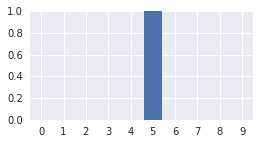

In [5]:
import matplotlib.pyplot as plt
import re

with open('predict.txt') as prediction:
  head = prediction.readline()
  result = prediction.readline()
r = re.compile("\[(.+)\]")
pred = r.search(result).group(1).split(',')
pred = map(lambda x: float(x), pred)

fig = plt.figure(figsize=(4,2))
subplot = fig.add_subplot(1,1,1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5,9.5)
subplot.set_ylim(0,1)
subplot.bar(range(10), pred, align='center')